# Xarray-spatial
### User Guide: Focal

#### Use datashader to render our images...

In [10]:
import numpy as np
import datashader as ds
from datashader.transfer_functions import shade
from datashader.transfer_functions import stack
from datashader.transfer_functions import dynspread
from datashader.transfer_functions import set_background
from datashader.colors import Elevation

import xrspatial

## Generate Terrain Data

The rest of the geo-related functions focus on raster data (or rasterized data, after a previous Datashader step that returns an Xarray object). To demonstrate using these raster-based functions, let's generate some fake terrain as an elevation raster:

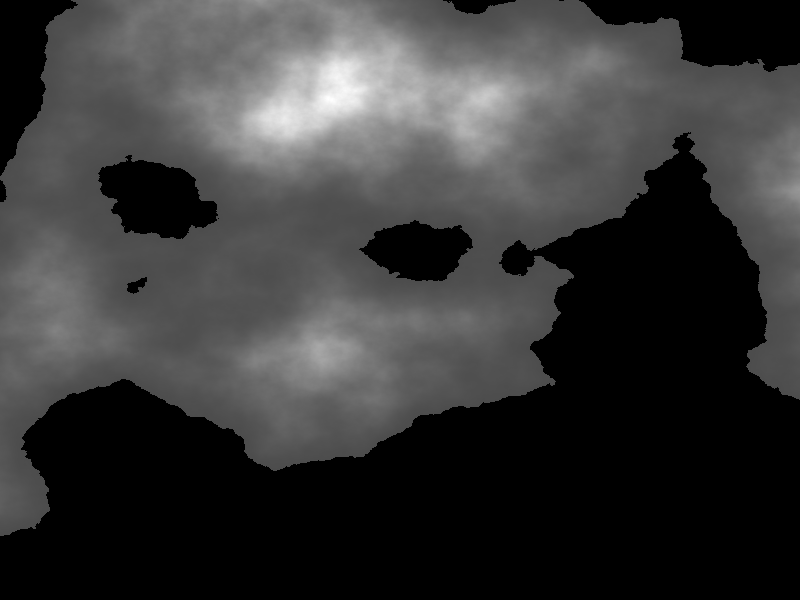

In [11]:
from xrspatial import generate_terrain

W = 800
H = 600

cvs = ds.Canvas(plot_width=W, plot_height=H, x_range=(-20e6, 20e6), y_range=(-20e6, 20e6))
terrain = generate_terrain(canvas=cvs)

shade(terrain, cmap=['black', 'white'], how='linear')

The grayscale value above shows the elevation linearly in intensity (with the large black areas indicating low elevation), but it will look more like a landscape if we map the lowest values to colors representing water, and the highest to colors representing mountaintops:

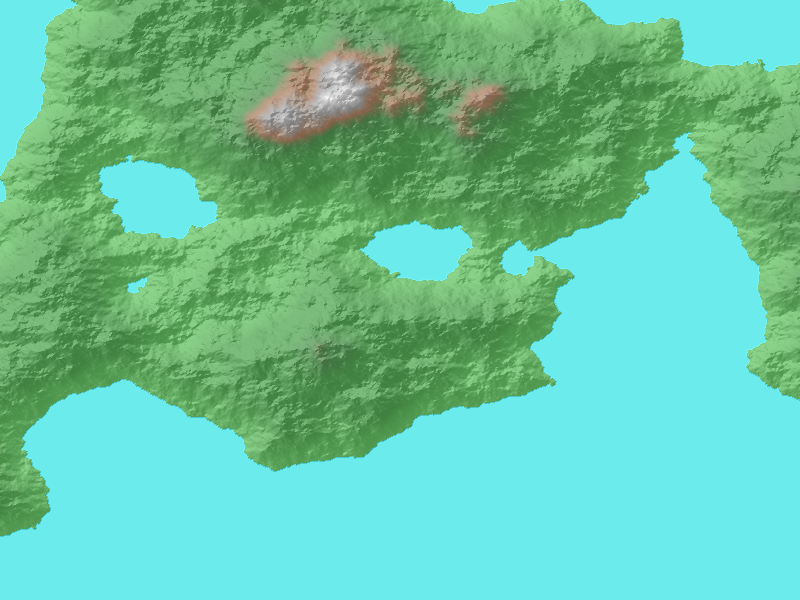

In [12]:
from xrspatial import hillshade
from datashader.colors import Set1
import pandas as pd

cvs = ds.Canvas(plot_width=W, plot_height=H, x_range=(-20, 20), y_range=(-20, 20))

terrain = generate_terrain(canvas=cvs)
terrain_shaded = shade(terrain, cmap=Elevation, alpha=128, how='linear')

illuminated = hillshade(terrain)
illuminated_shaded = shade(illuminated, cmap=['gray', 'white'], alpha=255, how='linear')

stack(illuminated_shaded, terrain_shaded)

## Focal Statistics and Convolutions

Similar to zonal statistics, focal statistics are used to calculate local statistics, but relative to a _focal_ point and a given neighborhood. The neighborhood is a user-defined kernel representing the cells which should be used in calculations. Currently, only circle and annulus kernels are implemented, but any custom kernel can be used given that:
- The kernel is a `numpy` array
- The kernel's dimensions are odd, so a `3x1` kernel is valid while a `3x2` is not. This is required for symmetry around the focal point in the current implementation.

The following example uses focal statistics to calculate the [toposiition position index (TPI)](http://www.jennessent.com/downloads/tpi-poster-tnc_18x22.pdf), which is a measure of local topographic position relative to its nearby neighbors. The TPI is scale dependent and will vary based on the inner and outer radii chosen for the annulus kernel. Once calculated, the TPI can be used to classify slope positions and landforms within landscapes, and can also be used as a numeric feature for model inputs.

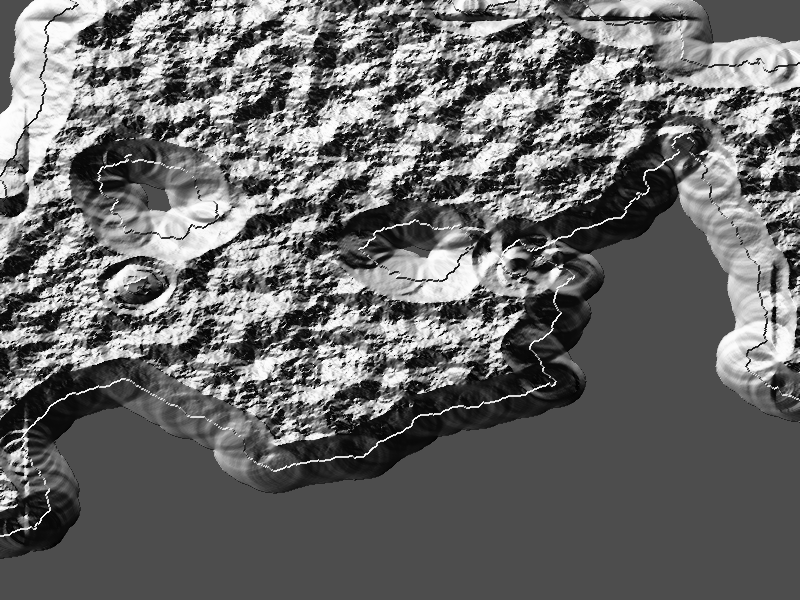

In [13]:
from xrspatial import focal

cellsize_x, cellsize_y = focal.calc_cellsize(terrain)
# Use an annulus kernel with a ring at a distance from 25-30 cells away from focal point
outer_radius = cellsize_x * 30
inner_radius = cellsize_x * 25
kernel = focal.annulus_kernel(cellsize_x, cellsize_y, outer_radius, inner_radius)
tpi = terrain - focal.apply(terrain, kernel)
tpi_terrain = hillshade(terrain - focal.apply(terrain, kernel))
tpi_terrain_shaded = shade(
    tpi_terrain, cmap=["white", "black"], alpha=255, how="linear"
)
stack(illuminated_shaded, tpi_terrain_shaded)

### Convolutions

The `focal.apply` function can be expensive depending on the size of the kernal and image. Additionally, we'd like to extend the ability to use custom convolution kernels on the raster. For example, we may want to apply some [kernels from image processing](https://en.wikipedia.org/wiki/Kernel_(image_processing)). Below we'll use the horizontal [Sobel operator](https://en.wikipedia.org/wiki/Sobel_operator), which is an approximation of the derivative in the horizontal dimension.

By default, the `convolution` module will use the local CUDA-enabled GPU unit, if available. To always use the CPU you can pass `use_cuda=False` to `convolution.convolve_2d`.

array([[ 1,  0, -1],
       [ 2,  0, -2],
       [ 1,  0, -1]])

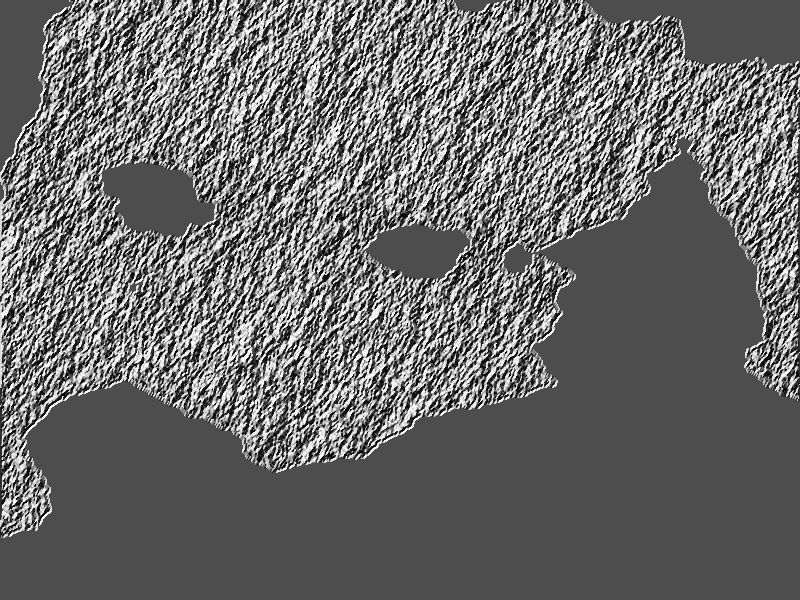

In [15]:
from xrspatial import convolution
from xarray import DataArray

# Use Sobel operator
kernel = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
display(kernel)
sobel = DataArray(
    convolution.convolve_2d(terrain.values, kernel),
    coords=terrain.coords,
    dims=terrain.dims,
    attrs=terrain.attrs,
)
sobel_terrain = hillshade(sobel)
sobel_terrain_shaded = shade(
    sobel_terrain, cmap=["white", "black"], alpha=255, how="linear"
)
stack(illuminated_shaded, sobel_terrain_shaded)